In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.discrete.discrete_model import Logit

import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
z_score = norm.ppf(0.975)

In [36]:
# Read the data
df = pd.read_csv('data/homework4.csv',index_col=0)

In [37]:
df["d"] = df["d"].apply(lambda x: 1 if x else 0)

In [38]:
df

,x1,x2,x3,d,y
1,0.789667,0.186084,0.601233,1,1.775711
2,0.091169,0.018968,0.602491,0,0.702007
3,0.839708,0.137707,0.439575,0,4.818743
4,0.373535,0.177271,0.419393,0,2.921435
5,0.141337,0.785985,0.140322,0,0.663376
...,...,...,...,...,...
4996,0.927083,0.088618,0.915360,1,2.716396
4997,0.265333,0.972859,0.537533,0,2.441886
4998,0.173289,0.357442,0.215186,0,-3.069551
4999,0.364623,0.510001,0.016217,0,2.979115


### Generate bootstrapped samples from the data

In [39]:
# Define sample size and number of bootstrapped samples
n = 500
n_boot = 200

# Create a list to store bootstrapped samples
boot_samples = []

# Draw bootstrapped samples and append to the list
for i in range(n_boot):
    boot_sample = df.sample(n=n, replace=True)
    boot_samples.append(boot_sample)

In [40]:
boot_samples[0]

,x1,x2,x3,d,y
1252,0.033107,0.148204,0.966218,1,3.566898
2102,0.364227,0.518468,0.297696,0,4.150937
2496,0.291778,0.798438,0.170189,0,-0.061651
194,0.387343,0.261828,0.743524,0,0.938103
545,0.222416,0.636887,0.712542,0,1.542592
...,...,...,...,...,...
4946,0.725051,0.542028,0.457353,0,1.678236
4918,0.133592,0.401532,0.826735,1,2.152019
3201,0.227931,0.190113,0.181538,0,1.071665
1811,0.107550,0.981498,0.712525,0,3.232346


# Problem 1

## Estimator 0: Unadjusted means

In [41]:
unadj_means_estimates = []

for i in range(200):
    bootstrap_sample = boot_samples[i]
    treated = bootstrap_sample[bootstrap_sample['d'] == 1]
    control = bootstrap_sample[bootstrap_sample['d'] == 0]
    unadj_mean_treated = treated['y'].mean()
    unadj_mean_control = control['y'].mean()
    unadj_means_estimates.append(unadj_mean_treated - unadj_mean_control)

In [42]:
# Compute the mean of the ATE estimates
mean_ate_unadjusted = np.mean(unadj_means_estimates)

# Compute standard deviation of ATE
std_ate_unadjusted = np.std(unadj_means_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_0 = mean_ate_unadjusted - z_score * std_ate_unadjusted
upper_CI_0 = mean_ate_unadjusted + z_score * std_ate_unadjusted

print("Mean of ATE:", mean_ate_unadjusted)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_0, upper_CI_0))

Mean of ATE: 1.40693170833634
95% CI of ATE: [1.054, 1.760]


## Estimator 1: Regression adjustment 
### 1.1 with full control variables 
### 1.2 with partial control variables

In [43]:
# Fit linear regression model
ate_ra_full_estimates = []
ate_ra_partial_estimates = []

for i in range(200):
    bootstrap_sample = boot_samples[i]
    
    y = bootstrap_sample['y']
    X_full = sm.add_constant(bootstrap_sample[['d', 'x1', 'x2', 'x3']])
    X_partial = sm.add_constant(bootstrap_sample[['d', 'x1']])
    
    #regression adjustment
    #full
    model_full = sm.OLS(y, X_full).fit()
    ate_ra_full_estimates.append(model_full.params['d'])
    #partial
    model_partial = sm.OLS(y, X_partial).fit()
    ate_ra_partial_estimates.append(model_partial.params['d'])

In [44]:
# Compute the mean of the ATE estimates
mean_ate_ra_full_estimates = np.mean(ate_ra_full_estimates)

# Compute standard deviation of ATE
std_ate_ra_full_estimates = np.std(ate_ra_full_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_1_1 = mean_ate_ra_full_estimates - z_score * std_ate_ra_full_estimates
upper_CI_1_1 = mean_ate_ra_full_estimates + z_score * std_ate_ra_full_estimates

print("Mean of ATE:", mean_ate_ra_full_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_1_1, upper_CI_1_1))

Mean of ATE: 1.0436839147175436
95% CI of ATE: [0.671, 1.416]


In [45]:
# Compute the mean of the ATE estimates
mean_ate_ra_partial_estimates = np.mean(ate_ra_partial_estimates)

# Compute standard deviation of ATE
std_ate_ra_partial_estimates = np.std(ate_ra_partial_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_1_2 = mean_ate_ra_partial_estimates - z_score * std_ate_ra_partial_estimates
upper_CI_1_2 = mean_ate_ra_partial_estimates + z_score * std_ate_ra_partial_estimates

print("Mean of ATE:", mean_ate_ra_partial_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_1_2, upper_CI_1_2))

Mean of ATE: 1.2987853583094333
95% CI of ATE: [0.943, 1.655]


## Estimator 2: 

In [ ]:
#Conditioning on propensity score
ate_pscore_full_estimates = []
ate_pscore_partial_estimates = []

for i in range(200):
    bootstrap_sample = boot_samples[i]
    
    bootstrap_sample['intercept'] = 1
    y = bootstrap_sample['y']
    X_full    = sm.add_constant(bootstrap_sample[['x1', 'x2', 'x3', 'intercept']])
    X_partial = sm.add_constant(bootstrap_sample[['x1', 'intercept']])
    
    #full
    model_full = Logit(endog=bootstrap_sample['d'], exog=X_full).fit()
    bootstrap_sample['ps_full'] = model_full.predict()
    X_full_1 = sm.add_constant(bootstrap_sample[['d', 'ps_full']])
    model_full_1 = sm.OLS(y, X_full_1).fit()
    ate_pscore_full_estimates.append(model_full_1.params['d'])
    
    #partial
    model_partial = Logit(endog=bootstrap_sample['d'], exog=X_partial).fit()
    bootstrap_sample['ps_partial'] = model_partial.predict()
    X_partial_1 = sm.add_constant(bootstrap_sample[['d', 'ps_partial']])
    model_partial_2 = sm.OLS(y, X_partial_1).fit()
    ate_pscore_partial_estimates.append(model_partial_2.params['d'])

In [47]:
# Compute the mean of the ATE estimates
mean_ate_pscore_full_estimates = np.mean(ate_pscore_full_estimates)

# Compute standard deviation of ATE
std_ate_pscore_full_estimates = np.std(ate_pscore_full_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_2_1 = mean_ate_pscore_full_estimates - z_score * std_ate_pscore_full_estimates
upper_CI_2_1 = mean_ate_pscore_full_estimates + z_score * std_ate_pscore_full_estimates

print("Mean of ATE:", mean_ate_pscore_full_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_2_1, upper_CI_2_1))

Mean of ATE: 1.0456937407137143
95% CI of ATE: [0.674, 1.417]


In [48]:
# Compute the mean of the ATE estimates
mean_ate_pscore_partial_estimates = np.mean(ate_pscore_partial_estimates)

# Compute standard deviation of ATE
std_ate_pscore_partial_estimates = np.std(ate_pscore_partial_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_2_2 = mean_ate_pscore_partial_estimates - z_score * std_ate_pscore_partial_estimates
upper_CI_2_2 = mean_ate_pscore_partial_estimates + z_score * std_ate_pscore_partial_estimates

print("Mean of ATE:", mean_ate_pscore_partial_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_2_2, upper_CI_2_2))

Mean of ATE: 1.2978089264023627
95% CI of ATE: [0.942, 1.654]


## Estimator 3

In [ ]:
ate_psweight_full_estimates = []
ate_psweight_partial_estimates = []

#Re-weighting based on propensity score
for i in range(200):
    bootstrap_sample = boot_samples[i]
    
    y = bootstrap_sample['y']
    X_full    = sm.add_constant(bootstrap_sample[['x1', 'x2', 'x3', 'intercept']])
    X_partial = sm.add_constant(bootstrap_sample[['x1', 'intercept']])
    
    #full
    model_full = Logit(endog=bootstrap_sample['d'], exog=X_full).fit()
    bootstrap_sample['ps_full'] = model_full.predict()
    ate_psweight_full = np.mean(bootstrap_sample['d']*y/bootstrap_sample['ps_full']-(1-bootstrap_sample['d'])*y/(1-bootstrap_sample['ps_full']))
    ate_psweight_full_estimates.append(ate_psweight_full)
    
    #partial
    model_partial = Logit(endog=bootstrap_sample['d'], exog=X_partial).fit()
    bootstrap_sample['ps_partial'] = model_partial.predict()
    ate_psweight_partial = np.mean(bootstrap_sample['d']*y/bootstrap_sample['ps_partial']-(1-bootstrap_sample['d'])*y/(1-bootstrap_sample['ps_partial']))
    ate_psweight_partial_estimates.append(ate_psweight_partial)


In [50]:
# Compute the mean of the ATE estimates
mean_ate_psweight_full_estimates = np.mean(ate_psweight_full_estimates)

# Compute standard deviation of ATE
std_ate_psweight_full_estimates = np.std(ate_psweight_full_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_3_1 = mean_ate_psweight_full_estimates - z_score * std_ate_psweight_full_estimates
upper_CI_3_1 = mean_ate_psweight_full_estimates + z_score * std_ate_psweight_full_estimates

print("Mean of ATE:", mean_ate_psweight_full_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_3_1, upper_CI_3_1))

Mean of ATE: 1.0501505510582136
95% CI of ATE: [0.680, 1.420]


In [51]:
# Compute the mean of the ATE estimates
mean_ate_psweight_partial_estimates = np.mean(ate_psweight_partial_estimates)

# Compute standard deviation of ATE
std_ate_psweight_partial_estimates = np.std(ate_psweight_partial_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_3_2 = mean_ate_psweight_partial_estimates - z_score * std_ate_psweight_partial_estimates
upper_CI_3_2 = mean_ate_psweight_partial_estimates + z_score * std_ate_psweight_partial_estimates

print("Mean of ATE:", mean_ate_psweight_partial_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_3_2, upper_CI_3_2))

Mean of ATE: 1.2930661793742484
95% CI of ATE: [0.936, 1.650]


## Estimator 4

In [52]:
ate_blk_ps_full_estimates = []
ate_blk_ps_partial_estimates = []

In [ ]:
for i in range(200):
    bootstrap_sample = boot_samples[i]
    
    #Blocking based on propensity score, say 20 blocks
    blocks = 20
    #full
    pmaxtrt = bootstrap_sample.loc[bootstrap_sample['d']==1, 'ps_full'].max()
    pmintrt = bootstrap_sample.loc[bootstrap_sample['d']==1, 'ps_full'].min()
    pmaxctl = bootstrap_sample.loc[bootstrap_sample['d']==0, 'ps_full'].max()
    pminctl = bootstrap_sample.loc[bootstrap_sample['d']==0, 'ps_full'].min()
    
    # Drop samples out of the overlap
    blk_sample_full = bootstrap_sample.loc[(bootstrap_sample['ps_full'] >= max(pmintrt, pminctl)) & 
                                            (bootstrap_sample['ps_full'] <= min(pmaxtrt, pmaxctl)), :]
    blk_sample_full['block'] = pd.cut(blk_sample_full['ps_full'], bins=np.linspace(0, 1, blocks+1), labels=False, include_lowest=True)
    
    # Compute BTE for each block
    bte_full = []
    for j in range(blocks):
        block = blk_sample_full.loc[blk_sample_full['block'] == j]
        bte_full.append(np.mean(block['d'] * block['y'] / block['ps_full'] - (1 - block['d']) * block['y'] / (1 - block['ps_full'])) * \
                   len(block) / len(blk_sample_full)) # Write it this way to handle possible NaN values
    ate_blk_ps_full_estimates.append(np.nansum(bte_full))
    
    
    #partial
    pmaxtrt = bootstrap_sample.loc[bootstrap_sample['d']==1, 'ps_partial'].max()
    pmintrt = bootstrap_sample.loc[bootstrap_sample['d']==1, 'ps_partial'].min()
    pmaxctl = bootstrap_sample.loc[bootstrap_sample['d']==0, 'ps_partial'].max()
    pminctl = bootstrap_sample.loc[bootstrap_sample['d']==0, 'ps_partial'].min()
    #drop sample out of the overlap
    blk_sample = bootstrap_sample.loc[(bootstrap_sample['ps_partial'] >= max(pmintrt, pminctl)) & 
                                      (bootstrap_sample['ps_partial'] <= min(pmaxtrt, pmaxctl)), :]
    blk_sample['block'] = pd.cut(blk_sample['ps_partial'], bins=np.linspace(0, 1, blocks+1), labels=False, include_lowest=True)
    bte = []
    for i in range(blocks):
        block = blk_sample.loc[blk_sample['block'] == i]
        bte.append(np.mean(block['d']*block['y']/block['ps_partial']-(1-block['d'])*block['y']/(1-block['ps_partial'])) * \
                   len(block) / len(blk_sample))
    ate_blk_ps_partial_estimates.append(np.nansum(bte))

In [54]:
# Compute the mean of the ATE estimates
mean_ate_blk_ps_full_estimates = np.mean(ate_blk_ps_full_estimates)

# Compute standard deviation of ATE
std_ate_blk_ps_full_estimates = np.std(ate_blk_ps_full_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_4_1 = mean_ate_blk_ps_full_estimates - z_score * std_ate_blk_ps_full_estimates
upper_CI_4_1 = mean_ate_blk_ps_full_estimates + z_score * std_ate_blk_ps_full_estimates

print("Mean of ATE:", mean_ate_blk_ps_full_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_4_1, upper_CI_4_1))

Mean of ATE: 1.0601786526597072
95% CI of ATE: [0.645, 1.476]


In [55]:
# Compute the mean of the ATE estimates
mean_ate_blk_ps_partial_estimates = np.mean(ate_blk_ps_partial_estimates)

# Compute standard deviation of ATE
std_ate_blk_ps_partial_estimates = np.std(ate_blk_ps_partial_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_4_2 = mean_ate_blk_ps_partial_estimates - z_score * std_ate_blk_ps_partial_estimates
upper_CI_4_2 = mean_ate_blk_ps_partial_estimates + z_score * std_ate_blk_ps_partial_estimates

print("Mean of ATE:", mean_ate_blk_ps_partial_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_4_2, upper_CI_4_2))

Mean of ATE: 1.30441372721763
95% CI of ATE: [0.936, 1.673]


## Estimator 5

In [56]:
ate_dbrobust_full_estimates = []
ate_dbrobust_partial_estimates = []

In [57]:
for i in range(200):
    bootstrap_sample = boot_samples[i]
    
    # full
    w_full = np.sqrt(bootstrap_sample['d'] / bootstrap_sample['ps_full'] + (1 - bootstrap_sample['d']) / (1 - bootstrap_sample['ps_full']))
    model_full = sm.WLS(bootstrap_sample['y'], sm.add_constant(bootstrap_sample[['d', 'x1', 'x2', 'x3']]), weights=w_full).fit()
    ate_dbrobust_full_estimates.append(model_full.params['d'])

    # partial
    w_partial = np.sqrt(bootstrap_sample['d'] / bootstrap_sample['ps_partial'] + (1 - bootstrap_sample['d']) / (1 - bootstrap_sample['ps_partial']))
    model_partial = sm.WLS(bootstrap_sample['y'], sm.add_constant(bootstrap_sample[['d', 'x1', 'x2', 'x3']]), weights=w_partial).fit()
    ate_dbrobust_partial_estimates.append(model_partial.params['d'])


In [58]:
# Compute the mean of the ATE estimates
mean_ate_dbrobust_full_estimates = np.mean(ate_dbrobust_full_estimates)

# Compute standard deviation of ATE
std_ate_dbrobust_full_estimates = np.std(ate_dbrobust_full_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_5_1 = mean_ate_dbrobust_full_estimates - z_score * std_ate_dbrobust_full_estimates
upper_CI_5_1 = mean_ate_dbrobust_full_estimates + z_score * std_ate_dbrobust_full_estimates

print("Mean of ATE:", mean_ate_dbrobust_full_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_5_1, upper_CI_5_1))

Mean of ATE: 1.0421152296940555
95% CI of ATE: [0.677, 1.407]


In [59]:
# Compute the mean of the ATE estimates
mean_ate_dbrobust_partial_estimates = np.mean(ate_dbrobust_partial_estimates)

# Compute standard deviation of ATE
std_ate_dbrobust_partial_estimates = np.std(ate_dbrobust_partial_estimates, ddof=1)

# Compute 95% CI of ATE
lower_CI_5_2 = mean_ate_dbrobust_partial_estimates - z_score * std_ate_dbrobust_partial_estimates
upper_CI_5_2 = mean_ate_dbrobust_partial_estimates + z_score * std_ate_dbrobust_partial_estimates

print("Mean of ATE:", mean_ate_dbrobust_partial_estimates)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_5_2, upper_CI_5_2))

Mean of ATE: 1.0374275557151924
95% CI of ATE: [0.670, 1.405]


In [60]:
# Create table
estimators = ['Estimator 0','Estimator 1.1','Estimator 1.2','Estimator 2.1','Estimator 2.2','Estimator 3.1','Estimator 3.2',
              'Estimator 4.1','Estimator 4.2','Estimator 5.1','Estimator 5.2']
mean_ate = [mean_ate_unadjusted, 
            mean_ate_ra_full_estimates, mean_ate_ra_partial_estimates, 
            mean_ate_pscore_full_estimates, mean_ate_pscore_partial_estimates,
            mean_ate_psweight_full_estimates, mean_ate_psweight_partial_estimates,
            mean_ate_blk_ps_full_estimates, mean_ate_blk_ps_partial_estimates,
            mean_ate_dbrobust_full_estimates, mean_ate_dbrobust_partial_estimates
            ]  
lower_bound = [lower_CI_0, lower_CI_1_1, lower_CI_1_2, lower_CI_2_1, lower_CI_2_2,lower_CI_3_1,lower_CI_3_2,
              lower_CI_4_1,lower_CI_4_2,lower_CI_5_1,lower_CI_5_2] 
upper_bound = [upper_CI_0, upper_CI_1_1, upper_CI_1_2, upper_CI_2_1, upper_CI_2_2, upper_CI_3_1, upper_CI_3_2,
              upper_CI_4_1, upper_CI_4_2,upper_CI_5_1, upper_CI_5_2]  

CI95 = [(lower_bound[i], upper_bound[i]) for i in range(len(mean_ate))]

df = pd.DataFrame({
    'mean of ATE': mean_ate,
    '95% CI of ATE': CI95
}, index=estimators)

df

,mean of ATE,95% CI of ATE
Estimator 0,1.406932,"(1.054112054649715, 1.759751362022965)"
Estimator 1.1,1.043684,"(0.671228506234715, 1.4161393232003723)"
Estimator 1.2,1.298785,"(0.942855703051102, 1.6547150135677646)"
Estimator 2.1,1.045694,"(0.6739100821307036, 1.4174773992967251)"
Estimator 2.2,1.297809,"(0.9418907683767554, 1.65372708442797)"
Estimator 3.1,1.050151,"(0.6804759199606549, 1.4198251821557724)"
Estimator 3.2,1.293066,"(0.9361343094489963, 1.6499980492995006)"
Estimator 4.1,1.060179,"(0.6445679626753642, 1.4757893426440503)"
Estimator 4.2,1.304414,"(0.9360373885018061, 1.6727900659334538)"
Estimator 5.1,1.042115,"(0.6767547776214845, 1.4074756817666265)"


# Problem 2

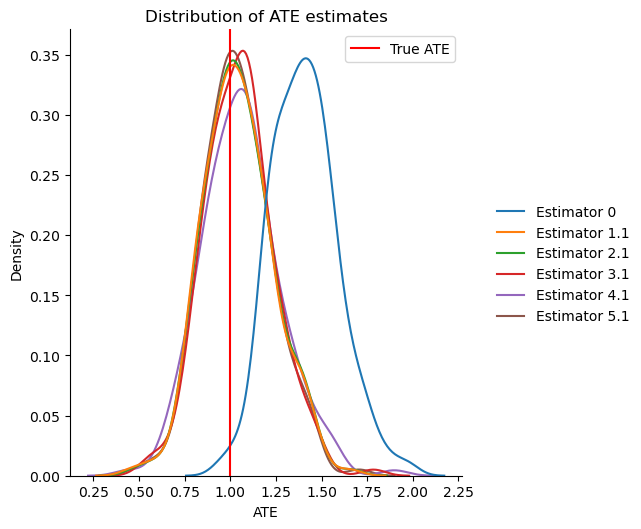

In [61]:
true_ate = 1

sns.displot(data={'Estimator 0': unadj_means_estimates,
                  'Estimator 1.1': ate_ra_full_estimates,
                  'Estimator 2.1': ate_pscore_full_estimates,
                  'Estimator 3.1': ate_psweight_full_estimates,
                  'Estimator 4.1': ate_blk_ps_full_estimates,
                  'Estimator 5.1': ate_dbrobust_full_estimates},
            kind="kde")
plt.axvline(x=true_ate, color='red', label='True ATE')
plt.title('Distribution of ATE estimates')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.legend()
plt.show()

It is evident that all estimators, except estimator 0, exhibit almost identical distributions in terms of mean and variance. Estimator 0 is commonly referred to as the naive estimator, and it has a biased mean of 1.4, although it has a similar variance to the other estimators. Additionally, the ATE for all the other estimators is centered around 1, which is the true ATE.

# Problem 3

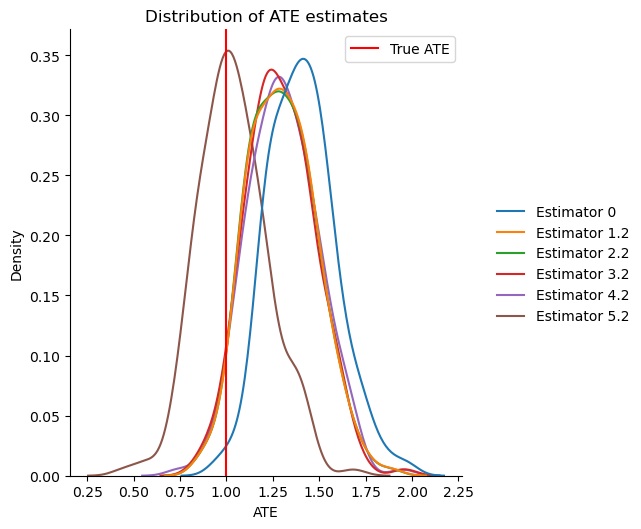

In [62]:
sns.displot(data={'Estimator 0': unadj_means_estimates,
                  'Estimator 1.2': ate_ra_partial_estimates,
                  'Estimator 2.2': ate_pscore_partial_estimates,
                  'Estimator 3.2': ate_psweight_partial_estimates,
                  'Estimator 4.2': ate_blk_ps_partial_estimates,
                  'Estimator 5.2': ate_dbrobust_partial_estimates},
            kind="kde")
plt.axvline(x=true_ate, color='red', label='True ATE')
plt.title('Distribution of ATE estimates')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.legend()
plt.show()

It is evident that all estimators, except for estimator 5.2 (Doubly robust estimator), have ATE values that are biased, and fall between the range of the true ATE with similar variance. The variance and mean ATE of these estimators are almost similar, and centralized around the true ATE value of 1. 

However, estimator 5.2, even though its propensity score is wrongly specified, has a correct final distribution that is very similar to estimator 5.1. The doubly robust estimator is robust enough, such that unless both the propensity score and conditional expectation are incorrect, its final estimate will still be reasonable.

# Problem 4

The results of problems 1-3 demonstrate the utility of the SOO method in estimating treatment effects in observational studies when all relevant observable characteristics of the units under study are accounted for. SOO relies on the assumption that conditioning on the observed variables is sufficient to control for confounding and selection bias. This assumption is validated in problem 2, where the estimator is shown to be unbiased when all other variables are controlled for.

However, when this assumption is violated, as in problem 3 where variables X2 and X3 are related to both the treatment assignment and outcome, and are not accounted for in the model, the estimated treatment effect becomes biased. Notwithstanding, the estimator still performs better than the naive estimator, as X1 is still controlled for, and accounts for some of the variation in Y.

Overall, the violation of the SOO assumptions can lead to biased estimates of treatment effects, underscoring the importance of ensuring that all relevant observable characteristics are accounted for when using the SOO method.

# Problem 5

In [63]:
ate_blk_ps_full_nodrop = []
ate_blk_ps_partial_nodrop = []

for i in range(200):
    sample = boot_samples[i]
    
    #Blocking based on propensity score, say 20 blocks, but without dropping
    blocks = 20
    #full
    sample['block'] = pd.cut(sample['ps_full'], bins=np.linspace(0, 1, blocks+1), labels=False, include_lowest=True)
    bte = []
    for i in range(blocks):
        block = sample.loc[sample['block'] == i]
        bte.append(np.mean(block['d']*block['y']/block['ps_full']-(1-block['d'])*block['y']/(1-block['ps_full'])) * \
                   len(block) / len(blk_sample)) 
    ate_blk_ps_full_nodrop.append(np.nansum(bte))
    
    #partial
    sample['block'] = pd.cut(sample['ps_partial'], bins=np.linspace(0, 1, blocks+1), labels=False, include_lowest=True)
    bte = []
    for i in range(blocks):
        block = sample.loc[sample['block'] == i]
        bte.append(np.mean(block['d']*block['y']/block['ps_partial']-(1-block['d'])*block['y']/(1-block['ps_partial'])) * \
                   len(block) / len(blk_sample)) #write in this way in case of NAN
    ate_blk_ps_partial_nodrop.append(np.nansum(bte))
    

In [64]:
# Compute the mean of the ATE estimates
mean_ate_blk_ps_full_nodrop = np.mean(ate_blk_ps_full_nodrop)

# Compute standard deviation of ATE
std_ate_blk_ps_full_nodrop = np.std(ate_blk_ps_full_nodrop, ddof=1)

# Compute 95% CI of ATE
lower_CI_6_1 = mean_ate_blk_ps_full_nodrop - z_score * std_ate_blk_ps_full_nodrop
upper_CI_6_1 = mean_ate_blk_ps_full_nodrop + z_score * std_ate_blk_ps_full_nodrop

print("Mean of ATE:", mean_ate_blk_ps_full_nodrop)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_6_1, upper_CI_6_1))

Mean of ATE: 1.0564894879861304
95% CI of ATE: [0.685, 1.428]


In [65]:
# Compute the mean of the ATE estimates
mean_ate_blk_ps_partial_nodrop = np.mean(ate_blk_ps_partial_nodrop)

# Compute standard deviation of ATE
std_ate_blk_ps_partial_nodrop = np.std(ate_blk_ps_partial_nodrop, ddof=1)

# Compute 95% CI of ATE
lower_CI_6_2 = mean_ate_blk_ps_partial_nodrop - z_score * std_ate_blk_ps_partial_nodrop
upper_CI_6_2 = mean_ate_blk_ps_partial_nodrop + z_score * std_ate_blk_ps_partial_nodrop

print("Mean of ATE:", mean_ate_blk_ps_partial_nodrop)
print("95% CI of ATE: [{:.3f}, {:.3f}]".format(lower_CI_6_2, upper_CI_6_2))

Mean of ATE: 1.3008714078211758
95% CI of ATE: [0.942, 1.660]


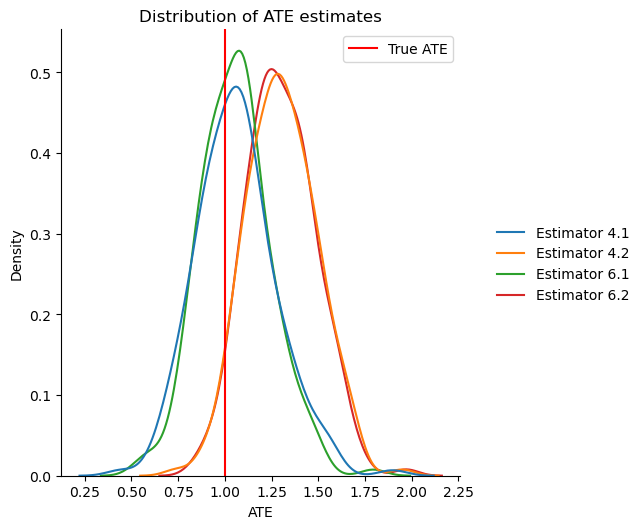

In [66]:
sns.displot(data= {'Estimator 4.1': ate_blk_ps_full_estimates,
                   'Estimator 4.2': ate_blk_ps_partial_estimates,
                   'Estimator 6.1': ate_blk_ps_full_nodrop,
                   'Estimator 6.2': ate_blk_ps_partial_nodrop
            },
            kind="kde")
plt.axvline(x=true_ate, color='red', label='True ATE')
plt.title('Distribution of ATE estimates')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.legend()
plt.show()

The difference in performance between with and without overlap is negligible. As a result, it is difficult to determine the impact of disregarding overlapping restrictions when comparing correctly specified models to misspecified models.